# 1. Iniciar Spark y leer capas previas

In [1]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Asegurar que la sesión previa se cierra para evitar errores de red
if 'spark' in locals():
    spark.stop()

print("Entorno de optimización preparado.")

Entorno de optimización preparado.


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, sum as spark_sum, count, max, min, avg, datediff

spark = SparkSession.builder \
    .appName("Medallion - Optimizaciones y ML") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Leer Silver (base para todo)
silver_path = "../../etapa3-silver-gold/data/silver/sales_clean.parquet"
df_silver = spark.read.parquet(silver_path)

print("Filas en Silver:", df_silver.count())
df_silver.printSchema()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/25 13:07:10 WARN Utils: Your hostname, Mac-mini.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.4 instead (on interface en1)
25/12/25 13:07:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/25 13:07:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Filas en Silver: 55500
root
 |-- sale_date: date (nullable = true)
 |-- store_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- product: string (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- total: double (nullable = true)
 |-- status: string (nullable = true)



# 2. Generar más datos para escalar (opcional, pero recomendado)

In [3]:
# Si quieres simular 100k+ filas, vuelve a Etapa 1 y cambia n_rows=100000
# O usa este pequeño snippet para agregar más datos a Silver (simulación rápida)
from faker import Faker
import numpy as np
import pandas as pd

fake = Faker()
np.random.seed(42)

extra_data = []
for _ in range(50000):  # 50k filas adicionales
    sale_date = fake.date_between(start_date="-1y", end_date="today")
    store_id = str(np.random.randint(1, 181)).zfill(3)
    customer_id = fake.uuid4()
    product = fake.random_element(["Laptop", "Smartphone", "Tablet", "Headphones"])
    quantity = np.random.randint(1, 6)
    price = round(np.random.uniform(50, 1200), 2)
    total = quantity * price
    status = "Completed"

    extra_data.append([sale_date, store_id, customer_id, product, quantity, price, total, status])

df_extra = pd.DataFrame(extra_data, columns=["sale_date", "store_id", "customer_id", "product", "quantity", "price", "total", "status"])
df_extra_spark = spark.createDataFrame(df_extra).withColumn("quantity", col("quantity").cast("int"))

# Append a Silver (simulación de crecimiento)
df_extra_spark.write.mode("append").parquet(silver_path)

# Recargamos df_silver para que Spark vea los nuevos datos en celdas posteriores
df_silver = spark.read.parquet(silver_path)
print("Filas totales ahora:", spark.read.parquet(silver_path).count())

Filas totales ahora: 105500


In [4]:
print("Filas totales ahora:", spark.read.parquet(silver_path).count())

Filas totales ahora: 105500


# 3. Optimizaciones básicas

In [5]:
# Cache para acelerar consultas repetidas
df_silver_cached = df_silver.cache()

#Particionamiento por fecha (mejora rendimiento en queries por día)
df_silver_cached.write.mode("overwrite").partitionBy("sale_date").parquet("../../etapa3-silver-gold/data/silver/sales_clean_partitioned.parquet")
print("Silver particionado guardado")

Silver particionado guardado


# 4. EDA y Feature Engineering (en Pandas para simplicidad)

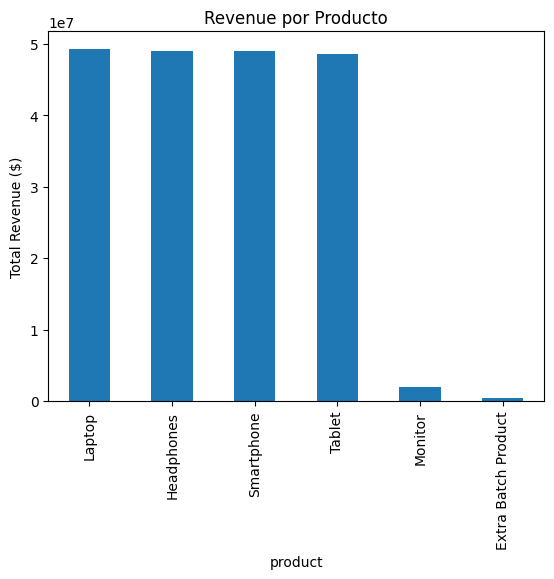

Tasa de churn aproximada: 74.84265402843602 %


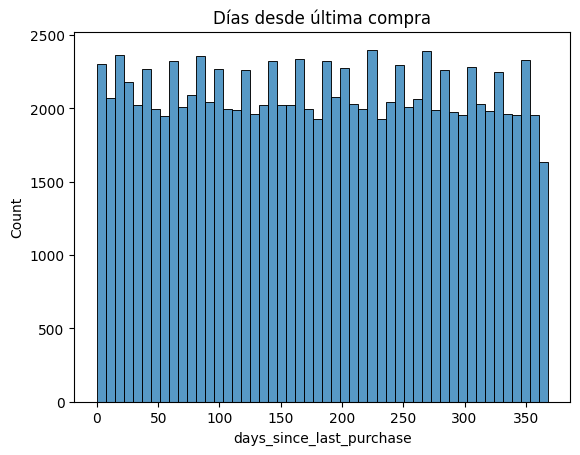

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Aseguramos paths por si se corre celda aislada
silver_path = "../../etapa3-silver-gold/data/silver/sales_clean.parquet"

# Intentamos usar la variable de memoria, si falla leemos disco
try:
    df_pd = df_silver.toPandas()
except NameError:
    print("Variable df_silver no encontrada, leyendo de disco...")
    df_pd = spark.read.parquet(silver_path).toPandas()

# Conversión 'Blindada' a Datetime
# errors='coerce' transformará valores no válidos a NaT en lugar de fallar
df_pd["sale_date"] = pd.to_datetime(df_pd["sale_date"], errors='coerce')

# 1. Revenue por producto
revenue_by_product = df_pd.groupby("product")["total"].sum().sort_values(ascending=False)
revenue_by_product.plot(kind="bar", color="#1f77b4")
plt.title("Revenue por Producto")
plt.ylabel("Total Revenue ($)")
plt.show()

# 2. Churn simple: clientes que no compraron en los últimos 90 días
# Eliminamos NaT si existen para evitar errores
df_pd = df_pd.dropna(subset=["sale_date"])

latest_date = df_pd["sale_date"].max()

df_customer = df_pd.groupby("customer_id").agg({"sale_date": "max"}).reset_index()
df_customer["sale_date"] = pd.to_datetime(df_customer["sale_date"])

# Calculo seguro de dias
df_customer["days_since_last_purchase"] = (latest_date - df_customer["sale_date"]).dt.days
df_customer["churn"] = (df_customer["days_since_last_purchase"] > 90).astype(int)

print("Tasa de churn aproximada:", df_customer["churn"].mean() * 100, "%")
sns.histplot(df_customer["days_since_last_purchase"], bins=50)
plt.title("Días desde última compra")
plt.show()

# 5. Modelo ML básico - Predicción de Churn

In [9]:
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 3.0 MB/s  0:00:03m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.3/30.3 MB 4.7 MB/s  0:00:06m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]
Note: you may need to restart the kernel to use updated packages.


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Features simples: total gastado, número de compras, días desde última compra
df_features = df_pd.groupby("customer_id").agg({
    "total": "sum",
    "quantity": "count",
    "sale_date": "max"
}).reset_index()

df_features["days_since_last"] = (latest_date - df_features["sale_date"]).dt.days
df_features["churn"] = (df_features["days_since_last"] > 90).astype(int)

X = df_features[["total", "quantity", "days_since_last"]]
y = df_features["churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7984
           1       1.00      1.00      1.00     23666

    accuracy                           1.00     31650
   macro avg       1.00      1.00      1.00     31650
weighted avg       1.00      1.00      1.00     31650

ROC AUC: 1.0
